In [1]:
import sys
import os
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt  # To visualize
import numpy as np
from sklearn import mixture

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

In [28]:
#Get folder location from args
print(str(sys.argv[0]))
base_directory = '/mnt/DownloadsWindowsShared/Experiment_compare_swarm_and_simulator/Experiment1/attempt3/'

#Processing the folders in order
experiment_type = []
experiment_type_part1 = []
experiment_type_part2 = []

for dir_name in os.listdir(base_directory):
    experiment_type_part1.append(int(dir_name.split('_')[0]))
    experiment_type_part2.append(str(dir_name.split('_')[1]))

experiment_type_part1.sort()
for dir_nr in range(len(experiment_type_part1)):
    experiment_type.append(str(experiment_type_part1[dir_nr]) + "_" + experiment_type_part2[dir_nr])

tmp_frames = [[],[],[],[]]
data_frames = []
for dir_name in experiment_type:
    for experiment_folder in os.listdir(base_directory + "/" + dir_name):
        tmp_frames[0].append(pd.read_csv(base_directory + "/" + dir_name + "/" + experiment_folder + "/merged/jp_consensus_process_proposal.csv", names=["txns", "duration"]))
        #tmp_frames[1].append(pd.read_csv(base_directory + "/" + dir_name + "/" + experiment_folder + "/merged/jp_mempool_process_incoming_transactions.csv", names=["txns", "duration"]))
        tmp_frames[1].append(pd.read_csv(base_directory + "/" + dir_name + "/" + experiment_folder + "/merged/jp_consensus_process_new_round.csv", names=["txns", "duration", "timeout_round", "timestamp"]))
        tmp_frames[2].append(pd.read_csv(base_directory + "/" + dir_name + "/" + experiment_folder + "/merged/jp_consensus_ensure_round_and_sync_up.csv", names=["txns", "duration"]))
        tmp_frames[3].append(pd.read_csv(base_directory + "/" + dir_name + "/" + experiment_folder + "/merged/jp_consensus_process_proposal_without_sync.csv", names=["txns", "duration"]))

    #Only take the log data for 1000 transactions
    for i in range(len(tmp_frames)):
        for j in range(len(tmp_frames[i])):
            tmp_frames[i][j] = tmp_frames[i][j][tmp_frames[i][j]['txns'] == max(tmp_frames[i][j]['txns'])]
    
    #merge the files
    for frames in tmp_frames:
        data_frames.append(pd.concat(frames))
    
    tmp_frames = [[],[],[],[]]
        
              
#convert duration from microseconds to milliseconds
i = 0
while i < len(data_frames):
    data_frames[i]["duration"] *= .001
    data_frames[i] = data_frames[i]
    i += 1

print("#entries(0):", len(data_frames[0]))
print("#entries(1):", len(data_frames[1]))
print("#entries(2):", len(data_frames[2]))
print("#entries(3):", len(data_frames[3]))
print("#entries(4):", len(data_frames[4]))
print(len(data_frames))

/home/jeanpierre/anaconda3/lib/python3.8/site-packages/ipykernel_launcher.py
#entries(0): 2465
#entries(1): 1234
#entries(2): 2467
#entries(3): 2465
#entries(4): 4053
60


In [3]:
def get_dist_parameters(index, calculate_round_sync_percentage):
    data = data_frames[index]['duration']
    data = data[data >= 40]
    
    percentage = 1
    if calculate_round_sync_percentage:
        percentage = 1 - ((len(data_frames[index]['duration']) - len(data)) / len(data_frames[index]['duration']))
    
    #Clean the data a bit
    data = data[data.between(data.quantile(0), data.quantile(.98))]
    data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]
    
    #Gamma dist
    a, loc_gamma, scale_gamma = stats.gamma.fit(data)
    gamma_fit = stats.gamma(a, loc_gamma, scale_gamma)
    p_gamma_fit = stats.kstest(data, gamma_fit.cdf)

    #Beta dist
    alpha, beta, loc_beta, scale_beta = stats.beta.fit(data)
    beta_fit = stats.beta(alpha, beta, loc_beta, scale_beta)
    p_beta_fit = stats.kstest(data, beta_fit.cdf)
    
    if p_gamma_fit[1] >= p_beta_fit[1]:
        sys.stdout.write("gamma:" + str(a) + ":" + str(loc_gamma) + ":" + str(scale_gamma))
    else:
        sys.stdout.write("beta:" + str(alpha) + ":" + str(beta) + ":" + str(loc_beta) + ":" + str(scale_beta))
        
    if calculate_round_sync_percentage:
        sys.stdout.write(":" + str(percentage))
        
    sample_size = int(round(5000*percentage))
    if p_gamma_fit[1] >= p_beta_fit[1]:
        return stats.gamma.rvs(a, loc_gamma, scale_gamma, size=sample_size)
    else:
        return stats.beta.rvs(alpha, beta, loc_beta, scale_beta, size=sample_size)

In [35]:
def get_mixture_multivariate_normal_distribution():
    for index in range(len(experiment_type)):
        data = data_frames[index*4 + 0]['duration']

        #Clean the data a bit
        data = data[data.between(data.quantile(0), data.quantile(.98))]
        data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]
        data = data.values.reshape(-1,1)

        model = mixture.GaussianMixture(n_components=2)
        model.fit(data)

        s = '{0},{1}:'
        s_last = '{0},{1}'
        sys.stdout.write(s.format(*model.weights_))
        sys.stdout.write(s.format(*model.means_.flatten()))
        sys.stdout.write(s_last.format(*model.covariances_.flatten()))
        print()
        
        
get_mixture_multivariate_normal_distribution()

0.48923538294107427,0.5107646170589261:266.5973481900396,496.0232066331726:241.3810983752449,1616.6726974131852
0.6719500247803976,0.32804997521960194:537.7517043679682,277.8130068875997:2915.9538784097535,371.9085601405695
0.7428130761350329,0.25718692386496833:566.2453548973725,305.0405839034579:2448.297079691804,819.7128127781052
0.20026774599295927,0.7997322540070416:331.3775702641691,606.3963191507902:853.8344296150987,2166.236964137281
0.8287558205657757,0.1712441794342267:680.1569123611613,371.1934795830785:5185.10824825639,1301.6834186589335
0.8426637042162943,0.15733629578370711:708.7075525298493,385.0675051854966:4951.370561651841,2903.399762353632
0.7894592959276014,0.21054070407240222:789.3404457325839,488.6245444344595:4050.1306713461026,11356.658512182234
0.8826531525539406,0.1173468474460603:724.9923384553229,367.03940981179505:10805.790419080793,4263.681078884212
0.3845493917086176,0.6154506082913784:656.4147443901996,919.8707889233974:43306.89146914568,4525.68716984344

In [36]:
dist = 'process_proposal'

if dist == 'process_proposal':
    get_mixture_multivariate_normal_distribution()
elif dist == 'process_new_round':
    for x in range(len(experiment_type)):
        index = x*len(tmp_frames) + 1
        get_dist_parameters(index, 0)
        print()
elif dist == 'ensure_round_and_sync_up':
    for x in range(len(experiment_type)):
        index = x*len(tmp_frames) + 2
        get_dist_parameters(index, 1)
        print()
elif dist == 'process_proposal_without_sync':
    for x in range(len(experiment_type)):
        index = x*len(tmp_frames) + 3
        get_dist_parameters(index, 0)
        print()
            
#samples_for_val_0 = []
#samples_for_val_1 = []

#for x in range(len(experiment_type)):
#    for i in range(len(tmp_frames)):
#        index = (x*len(tmp_frames)) + i
#        if i == 2:
#            samples = get_dist_parameters(index, 1)
#            samples_for_val_0 = samples_for_val_0 + [samples]
#        elif i == 3:
#            samples = get_dist_parameters(index, 0)
#            samples_for_val_1 = samples_for_val_1 + [samples]
#        else:
#            get_dist_parameters(index, 0)
#        if i < len(tmp_frames) - 1:
#            sys.stdout.write(',')
#    print()
#    print()
    

0.48923538294107427,0.5107646170589261:266.5973481900396,496.0232066331726:241.3810983752449,1616.6726974131852
0.32804997521960194,0.6719500247803976:277.8130068875997,537.7517043679682:371.9085601405695,2915.9538784097535
0.25718692386496833,0.7428130761350329:305.0405839034579,566.2453548973725:819.7128127781052,2448.297079691804
0.7997322540070416,0.20026774599295927:606.3963191507902,331.3775702641691:2166.236964137281,853.8344296150987
0.8287550883325915,0.1712449116674115:680.1571042674182,371.19387194504986:5185.070622414267,1301.7163937355122
0.8427327665841928,0.15726723341580998:708.6925910870175,385.00555426478917:4953.746417804819,2895.661321132621
0.7899479934114498,0.2100520065885455:789.271533207053,488.1840735503583:4062.919689937038,11270.826951099689
0.8829344256436708,0.11706557435633191:724.9168684517902,366.7485688691609:10820.94622504777,4233.169924311024
0.3864865963528039,0.6135134036471941:657.4635456433351,920.0419679812765:43361.52804419537,4497.059301115639

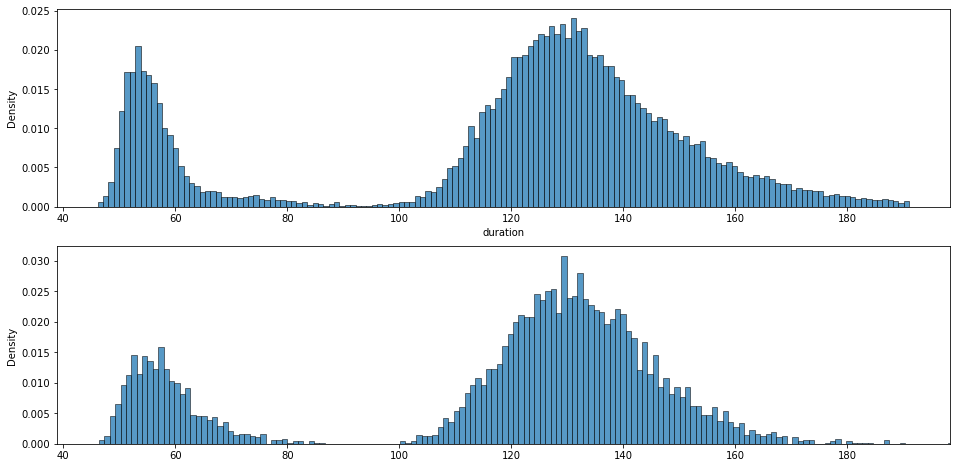

KstestResult(statistic=0.057486894632632346, pvalue=8.968070388956911e-12)
#Samples real: 18687
#Samples dist: 5000


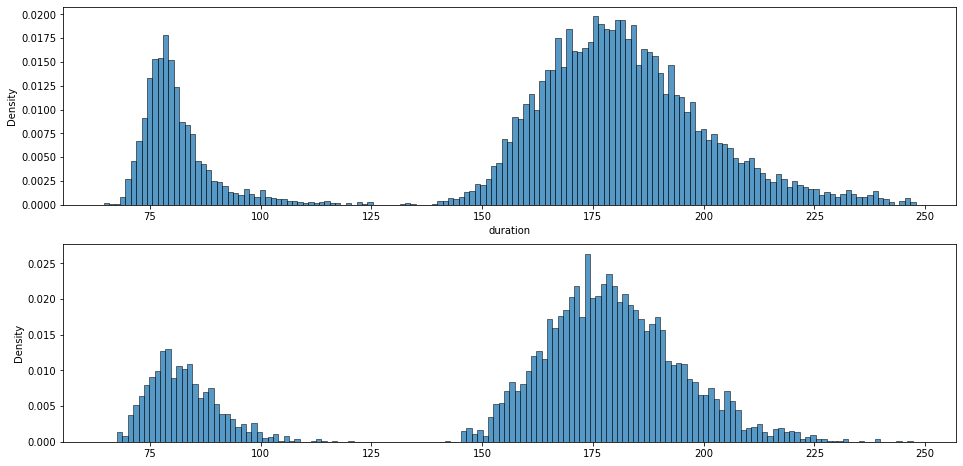

KstestResult(statistic=0.05445566636446056, pvalue=1.1399430288605572e-08)
#Samples real: 8824
#Samples dist: 5000


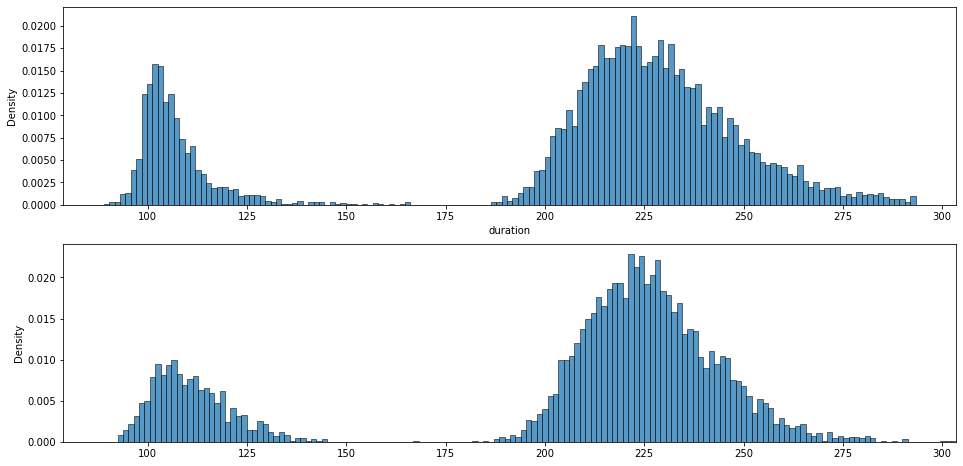

KstestResult(statistic=0.051949296864920655, pvalue=1.427388010011299e-07)
#Samples real: 7751
#Samples dist: 5000


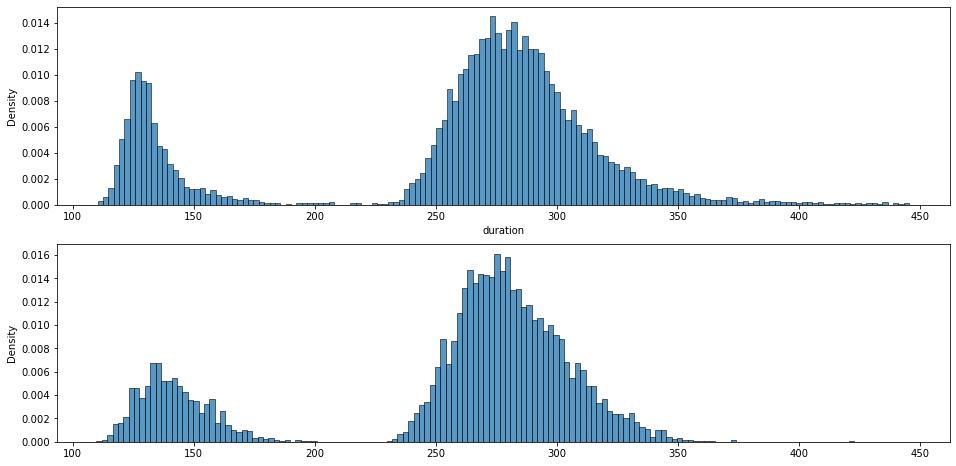

KstestResult(statistic=0.06879227053140097, pvalue=2.575896403652653e-14)
#Samples real: 10350
#Samples dist: 5000


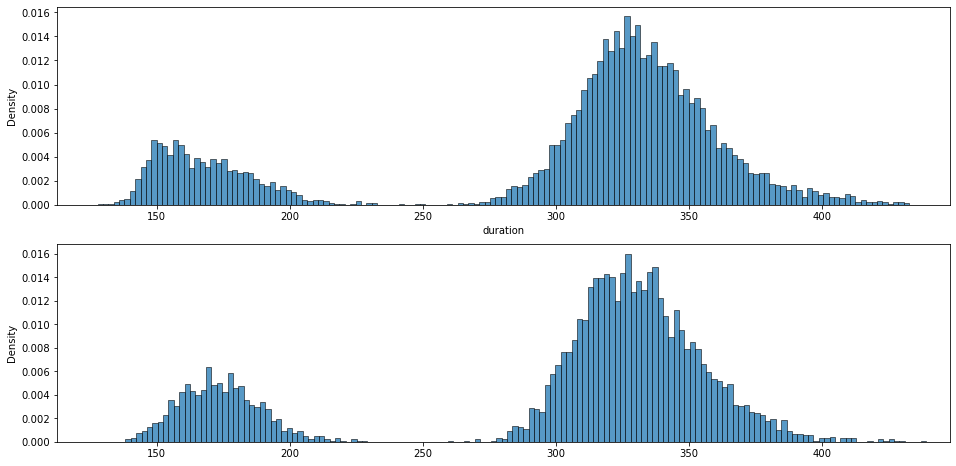

KstestResult(statistic=0.045963584023029865, pvalue=3.5236220760070935e-06)
#Samples real: 8337
#Samples dist: 5000


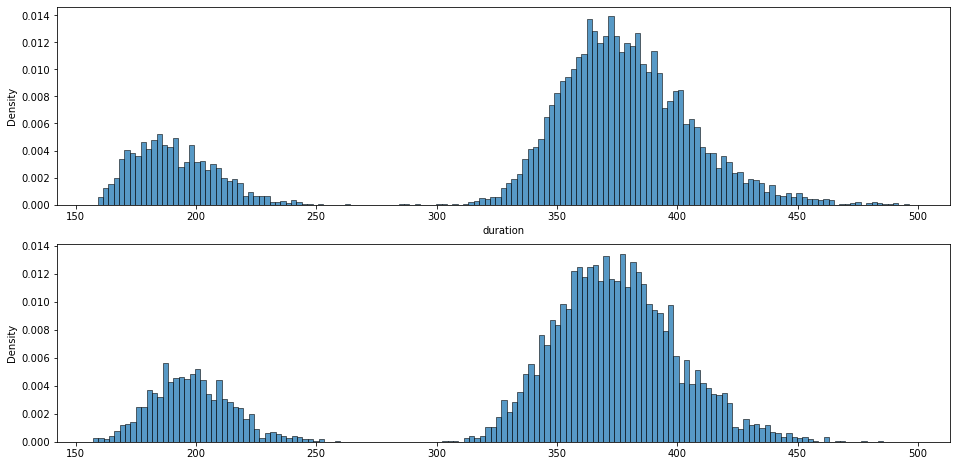

KstestResult(statistic=0.0427947563323952, pvalue=5.1829560349991866e-05)
#Samples real: 6751
#Samples dist: 5000


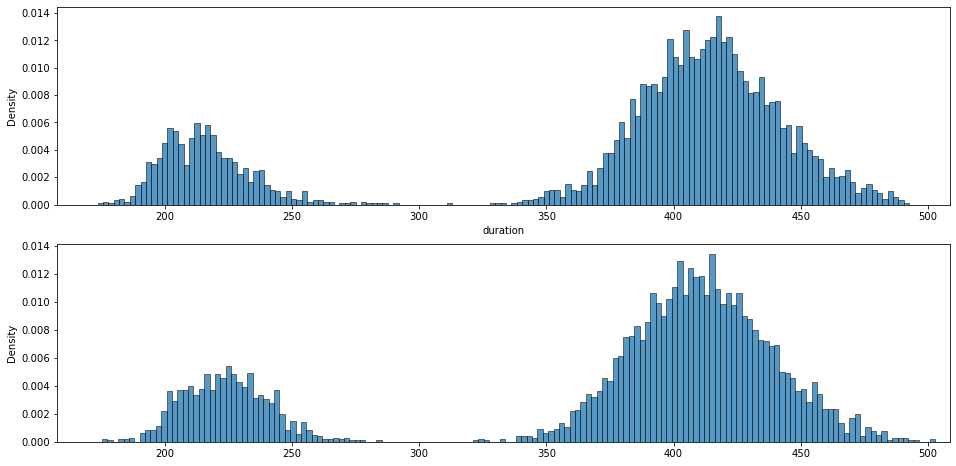

KstestResult(statistic=0.050085913528591354, pvalue=1.7444557094292712e-05)
#Samples real: 4302
#Samples dist: 5000


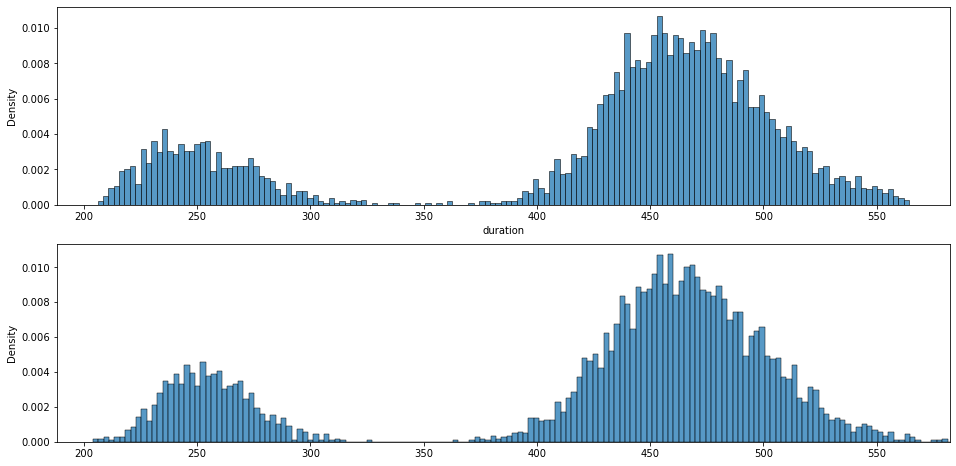

KstestResult(statistic=0.028649208502939845, pvalue=0.04139406398106871)
#Samples real: 4422
#Samples dist: 5000


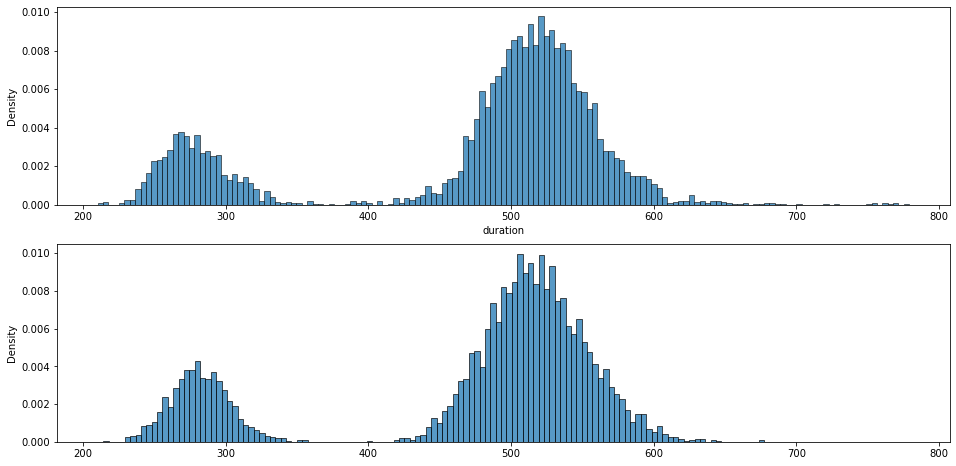

KstestResult(statistic=0.02985592511451902, pvalue=0.022318682060266437)
#Samples real: 5021
#Samples dist: 5000


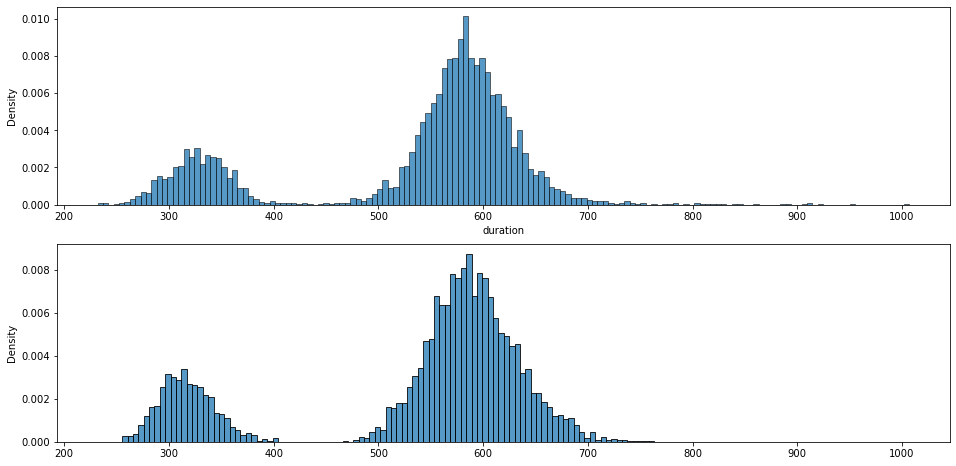

KstestResult(statistic=0.0382975975975976, pvalue=0.0009984882429083797)
#Samples real: 5328
#Samples dist: 5000


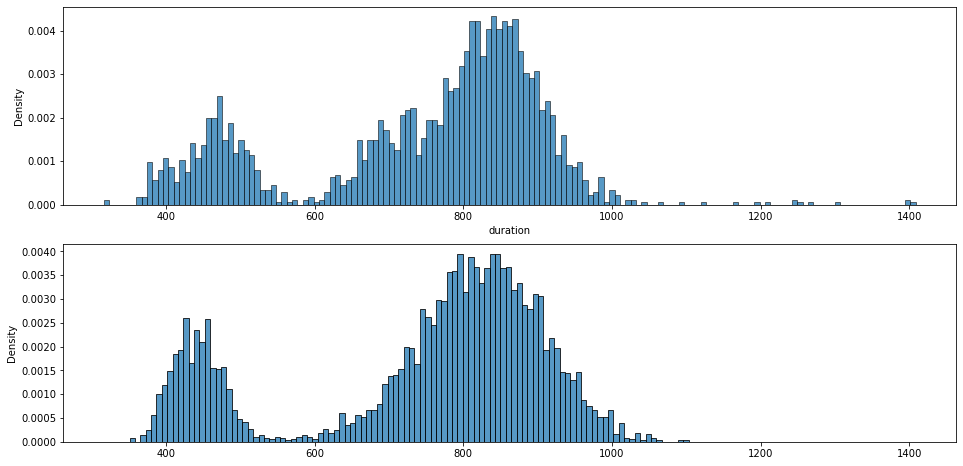

KstestResult(statistic=0.054227748044462745, pvalue=0.00012698402539124132)
#Samples real: 2429
#Samples dist: 5000


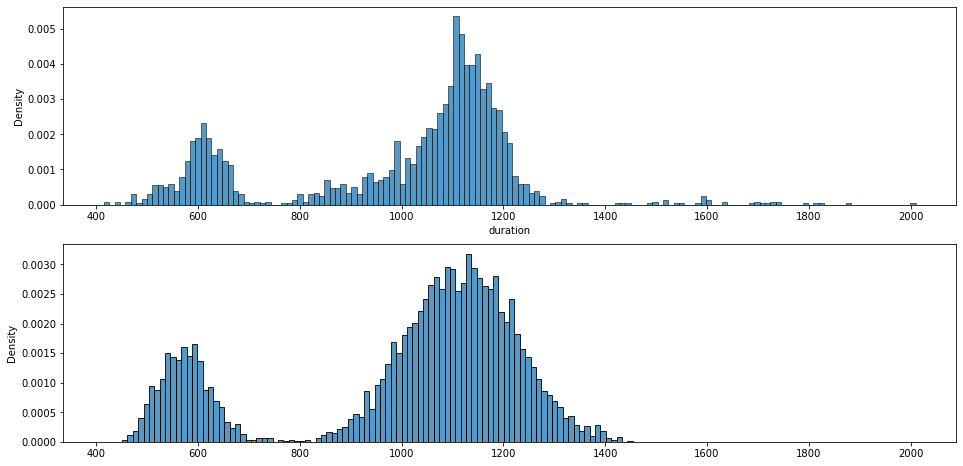

KstestResult(statistic=0.09597359855334539, pvalue=9.541256673628595e-13)
#Samples real: 2212
#Samples dist: 5000


IndexError: list index out of range

In [48]:
# MIXTURE MODEL FROM 2 DISTRIBUTIONS
def plot_validate_dist(samples_for_val_0, samples_for_val_1):
    for index in range(len(experiment_type)):
        
        data_dist = np.add(samples_for_val_0[index], samples_for_val_1[index][:len(samples_for_val_0[index])])
        data_dist = np.append(data_dist, samples_for_val_1[index][len(samples_for_val_0[index]):])

        fig, (ax0, ax1) = plt.subplots(2,1,figsize=(16,8))

        data_real = data_frames[index*4 + 0]['duration']
        data_real = data_real[data_real.between(data_real.quantile(0), data_real.quantile(.98))]
        data_real = data_real[(data_real <= data_real.mean() + 3*data_real.std()) & (data_real >= data_real.mean() - 3*data_real.std())]

        x_axis_range = int(max(data_real) - min(data_real))
        sns.histplot(data_real, ax=ax0, stat="density", label="Real Data", binwidth=x_axis_range/150)
        sns.histplot(data_dist, ax=ax1, stat="density", label="Real Data", binwidth=x_axis_range/150)
        ax1.set_xlim(ax0.get_xlim())
        plt.show()

        p_value = stats.ks_2samp(data_real, data_dist)
        print(p_value)
        print("#Samples real: " + str(len(data_real)))
        print("#Samples dist: " + str(len(data_dist)))
    
plot_validate_dist(samples_for_val_0, samples_for_val_1)

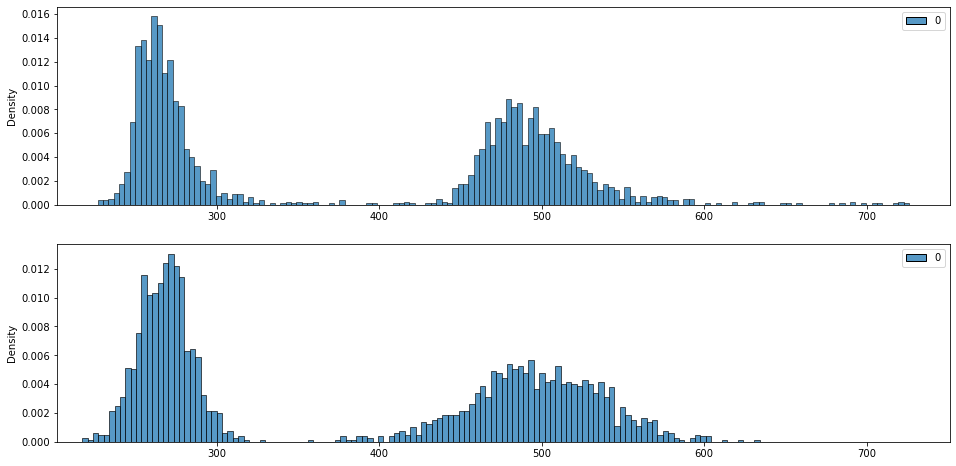

P-value = 0.0002543122809160668

[[496.02320663]
 [266.59734819]]

[0.51076462 0.48923538]

[[[1616.67269741]]

 [[ 241.38109838]]]


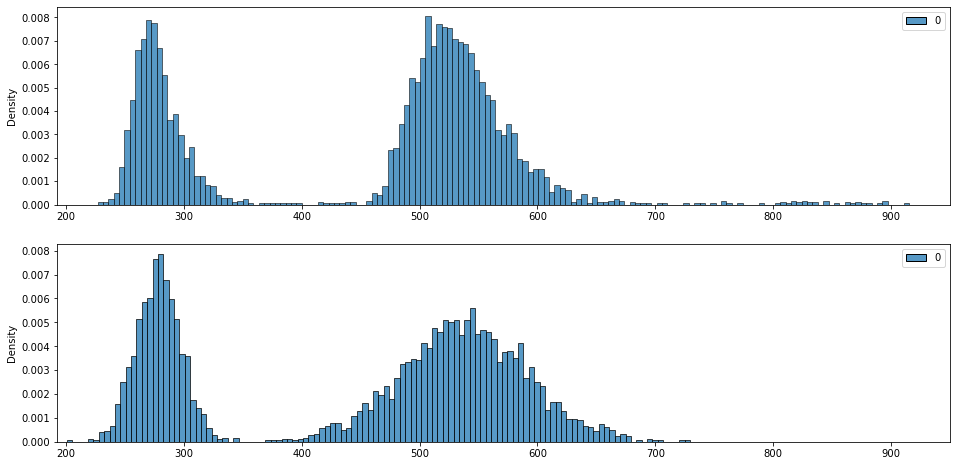

P-value = 3.29106000411579e-11

[[277.81300689]
 [537.75170437]]

[0.32804998 0.67195002]

[[[ 371.90856014]]

 [[2915.95387841]]]


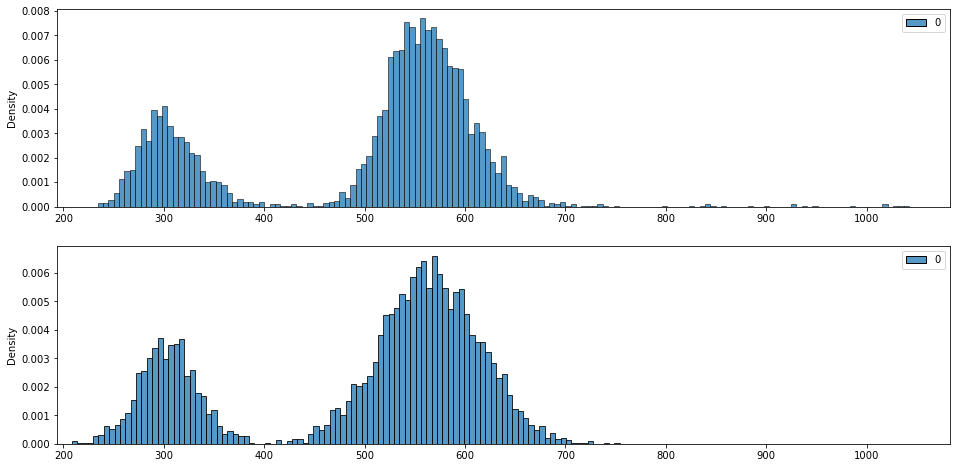

P-value = 5.3916330295584154e-05

[[566.2453549]
 [305.0405839]]

[0.74281308 0.25718692]

[[[2448.29707969]]

 [[ 819.71281278]]]


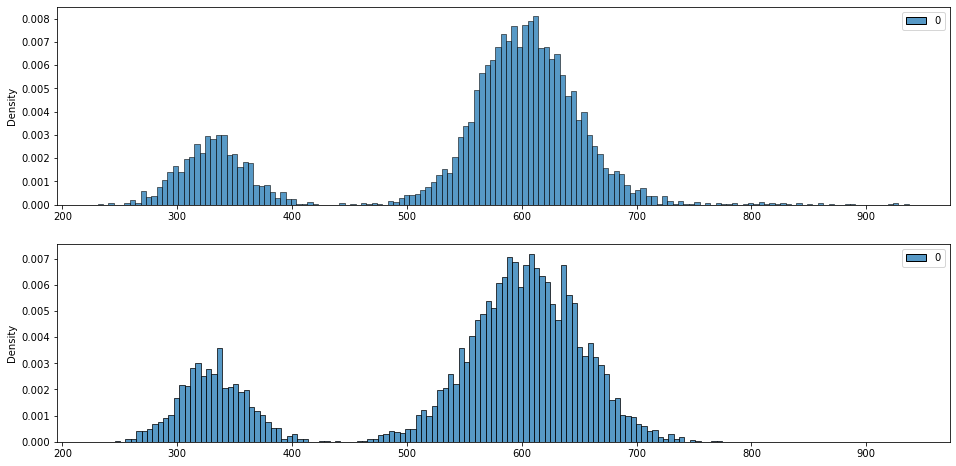

P-value = 0.000908896478143038

[[331.37757026]
 [606.39631915]]

[0.20026775 0.79973225]

[[[ 853.83442962]]

 [[2166.23696414]]]


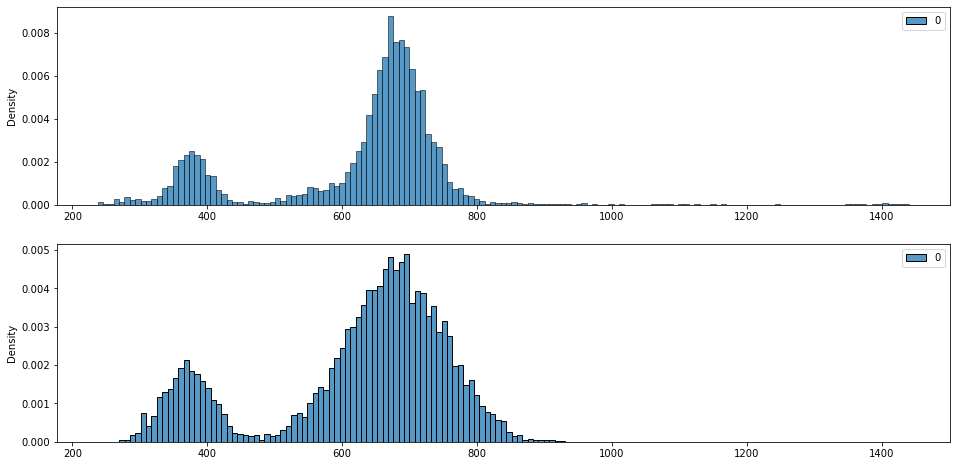

P-value = 1.131168345716745e-27

[[680.15870906]
 [371.19715719]]

[0.82874896 0.17125104]

[[[5184.7561349 ]]

 [[1301.99274877]]]


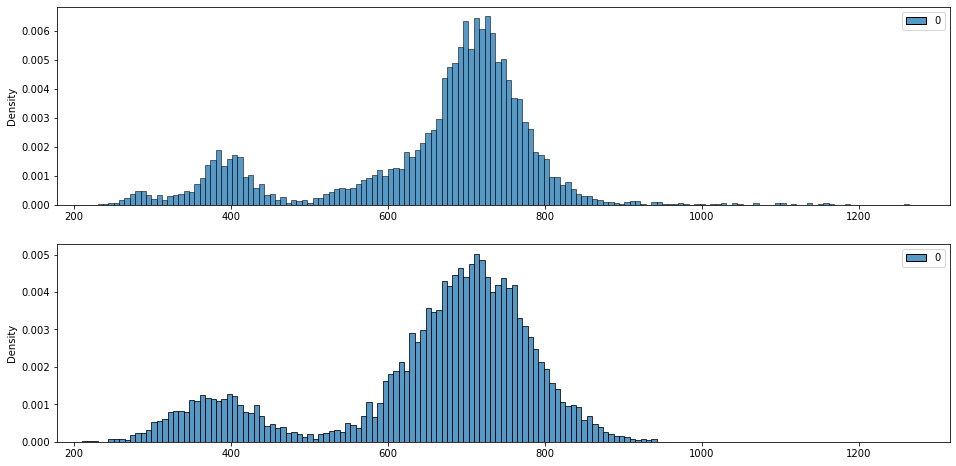

P-value = 4.472349969550701e-08

[[708.70755253]
 [385.06750519]]

[0.8426637 0.1573363]

[[[4951.37056165]]

 [[2903.39976235]]]


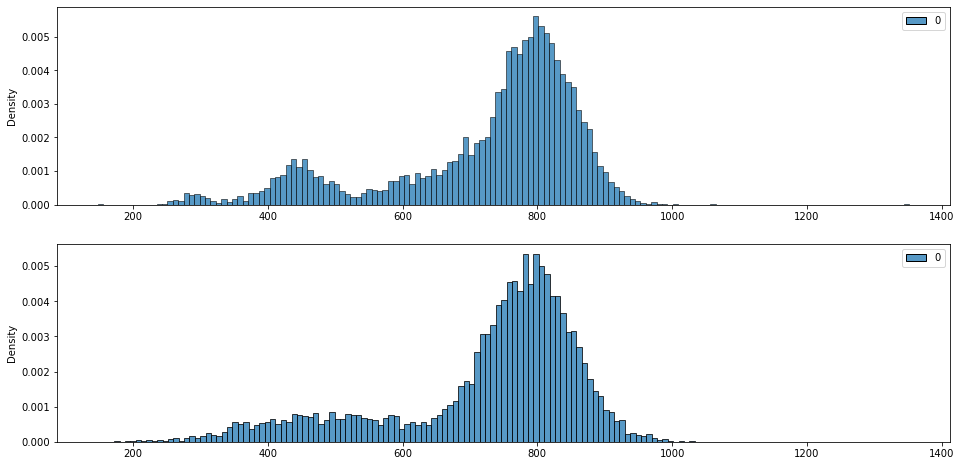

P-value = 0.056402136133142766

[[789.34044573]
 [488.62454443]]

[0.7894593 0.2105407]

[[[ 4050.13067135]]

 [[11356.65851218]]]


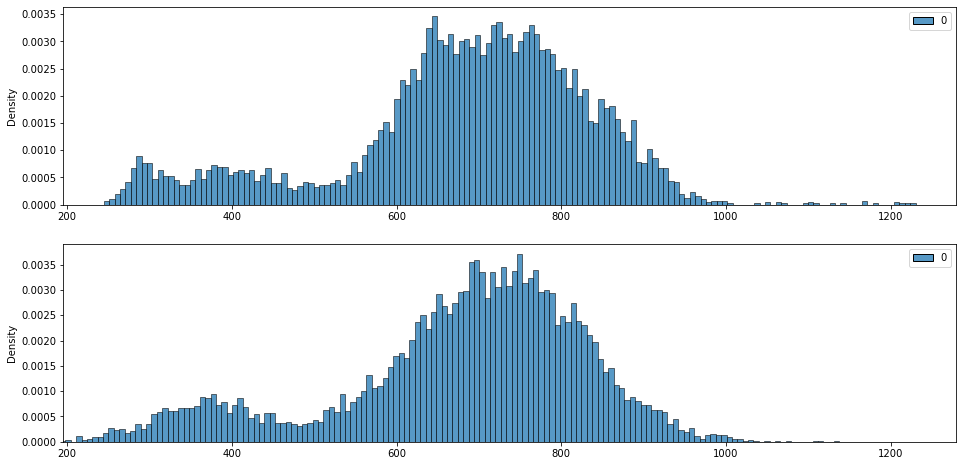

P-value = 0.04294059980531904

[[366.94024994]
 [724.96671609]]

[0.11725118 0.88274882]

[[[ 4253.2352277]]

 [[10810.9239559]]]


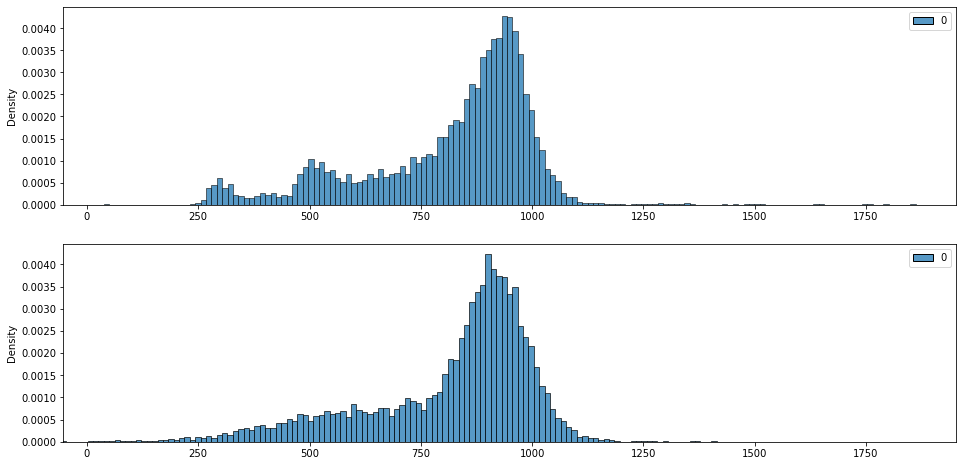

P-value = 0.010972705472982038

[[657.52155559]
 [920.05145492]]

[0.38659417 0.61340583]

[[[43364.50532079]]

 [[ 4495.47407422]]]


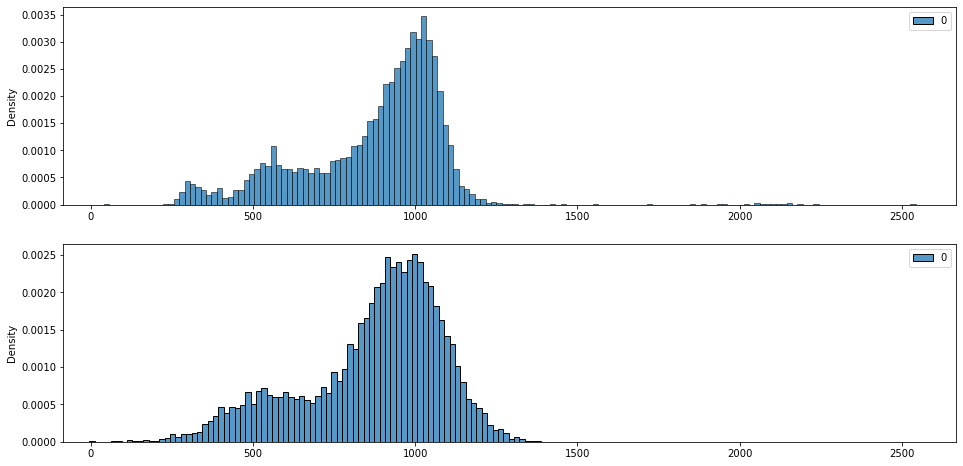

P-value = 4.7047807597326355e-12

[[566.17879892]
 [968.99299887]]

[0.24174128 0.75825872]

[[[22544.96470513]]

 [[14911.28495247]]]


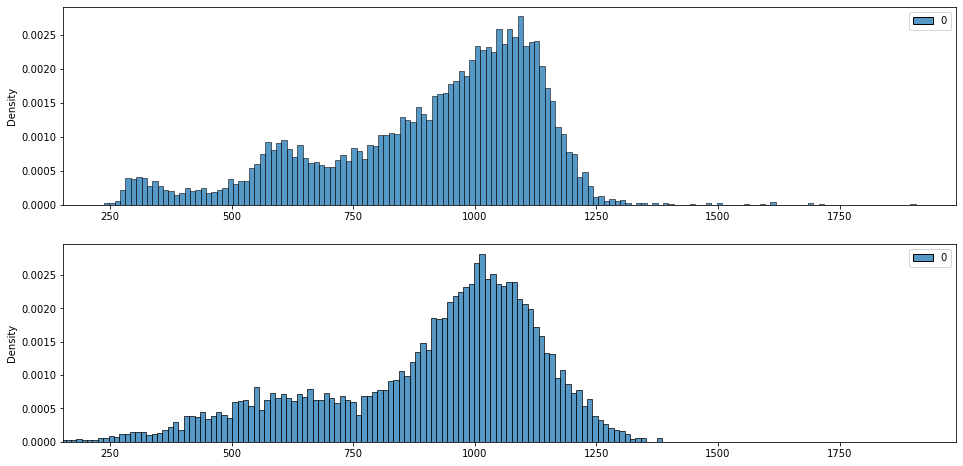

P-value = 0.007072732176990274

[[ 635.21139459]
 [1028.54200655]]

[0.30059651 0.69940349]

[[[31586.96651992]]

 [[12855.32745165]]]


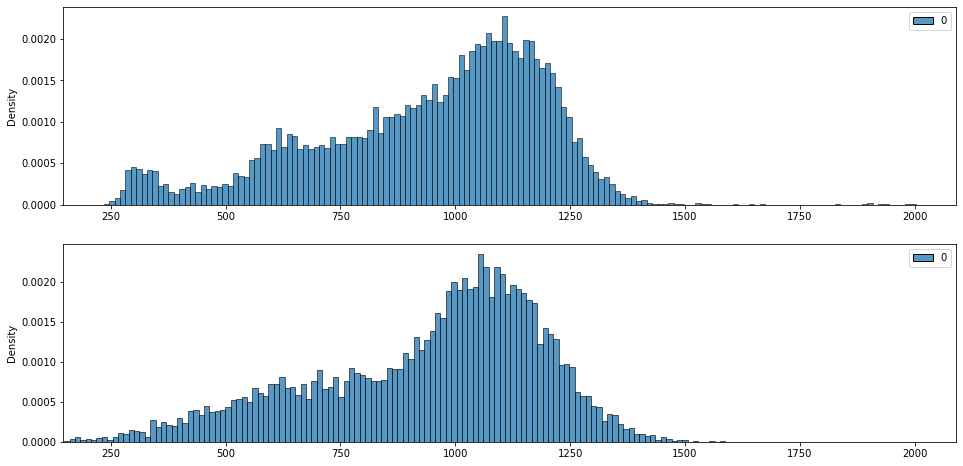

P-value = 0.03138304896107229

[[1081.99581373]
 [ 669.05930795]]

[0.66471817 0.33528183]

[[[18232.05853885]]

 [[38551.40677891]]]


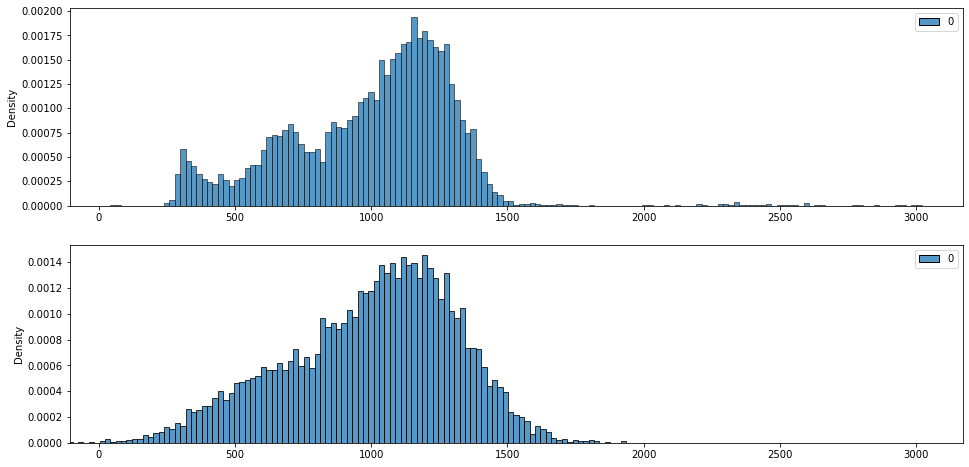

P-value = 6.163296421889521e-13

[[1127.71809832]
 [ 618.54621201]]

[0.75089277 0.24910723]

[[[45744.37282307]]

 [[42001.22842954]]]


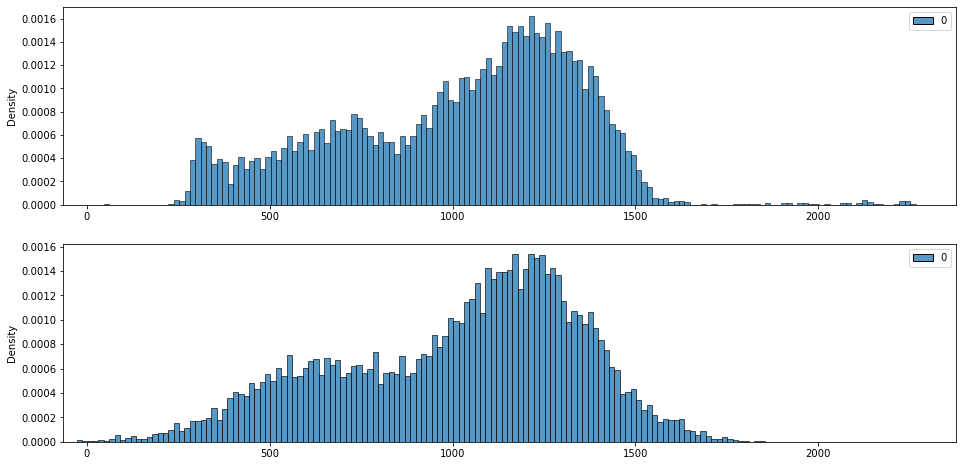

P-value = 0.06092353845976723

[[ 631.88072282]
 [1201.42854306]]

[0.31842191 0.68157809]

[[[41226.5210648 ]]

 [[35066.95169387]]]


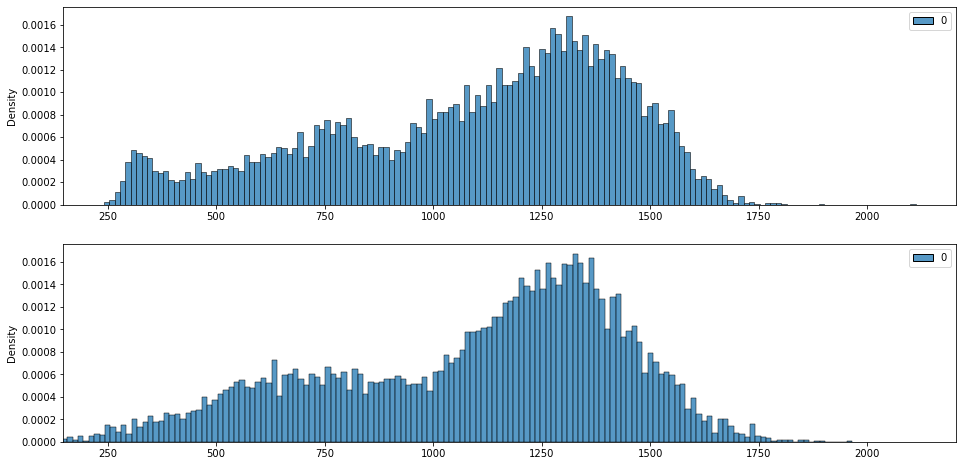

P-value = 0.10597473358995063

[[1291.58416009]
 [ 699.81103038]]

[0.67025987 0.32974013]

[[[31370.98448691]]

 [[51675.88149338]]]


In [30]:
for index in range(len(experiment_type)):
    fig, (ax0, ax1) = plt.subplots(2,1,figsize=(16,8))

    data = data_frames[index*4 + 0]['duration']

    #Clean the data a bit
    data = data[data.between(data.quantile(0), data.quantile(.98))]
    data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]
    data = data.values.reshape(-1,1)

    model = mixture.GaussianMixture(n_components=2)
    model.fit(data)
    data_samples = model.sample(len(data))

    x_axis_range = int(max(data) - min(data))
    sns.histplot(data, ax=ax0, stat="density", label="Real Data", binwidth=x_axis_range/150)
    sns.histplot(data_samples[0], ax=ax1, stat="density", label="Real Data", binwidth=x_axis_range/150)
    ax1.set_xlim(ax0.get_xlim())
    plt.show()

    p_value = stats.ks_2samp(np.array(data).flatten(), data_samples[0].flatten())
    print('P-value = ' + str(p_value[1]))
    print()
    print(model.means_)
    print()
    print(model.weights_)
    print()
    print(model.covariances_)

Gamma p score: KstestResult(statistic=0.25508057382114707, pvalue=3.1088277040286016e-292)
Beta p score: KstestResult(statistic=0.20753474262967403, pvalue=1.2987239595167003e-192)
Percentage of data cleaned: 3.2343987823439875
Gamma p score: KstestResult(statistic=0.20924338056567626, pvalue=4.620231807771114e-134)
Beta p score: KstestResult(statistic=0.1598019591982186, pvalue=4.682568537891215e-78)
Percentage of data cleaned: 2.4950939164564057
Gamma p score: KstestResult(statistic=0.2024574509181304, pvalue=2.1135409098567753e-122)
Beta p score: KstestResult(statistic=0.3232141461833222, pvalue=5.89094677e-316)
Percentage of data cleaned: 2.0213687554143807
Gamma p score: KstestResult(statistic=0.21211900381573334, pvalue=9.061379193717999e-128)
Beta p score: KstestResult(statistic=0.3702513158758687, pvalue=0.0)
Percentage of data cleaned: 2.0060790273556233
Gamma p score: KstestResult(statistic=0.19310034826197847, pvalue=2.531060185633915e-108)
Beta p score: KstestResult(statist

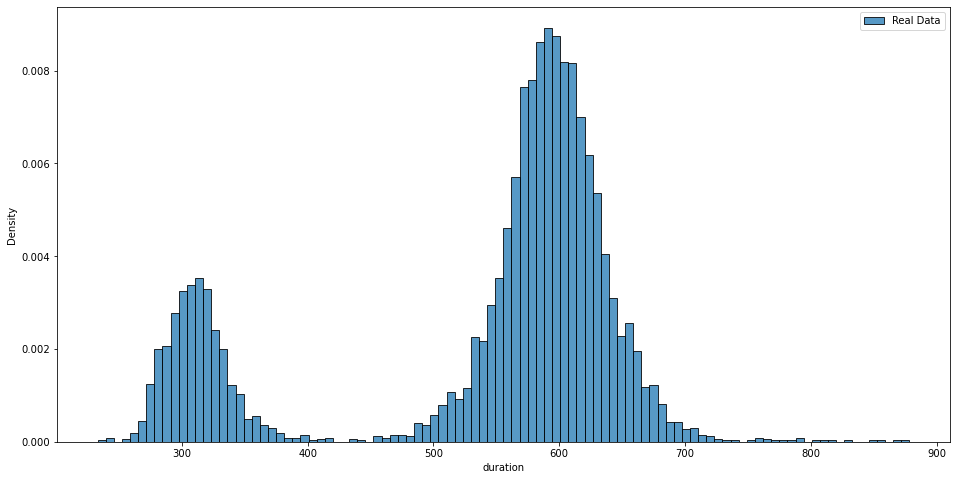

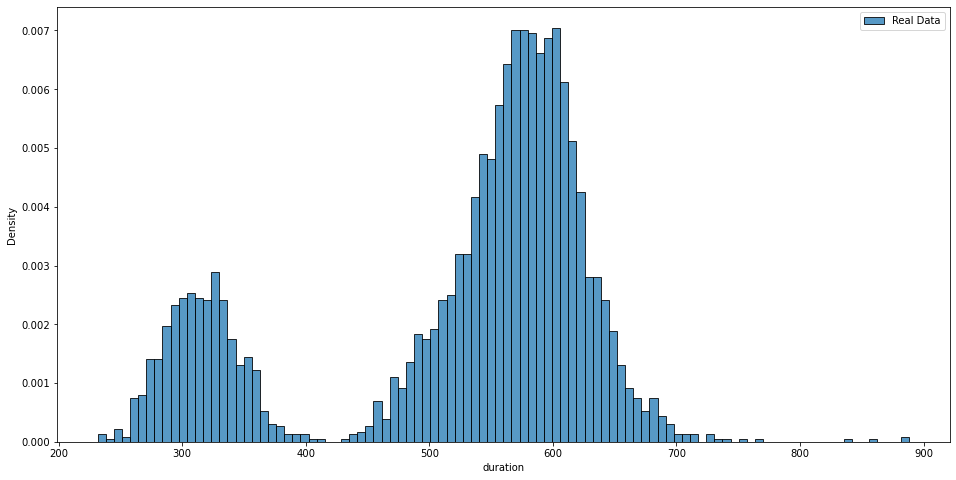

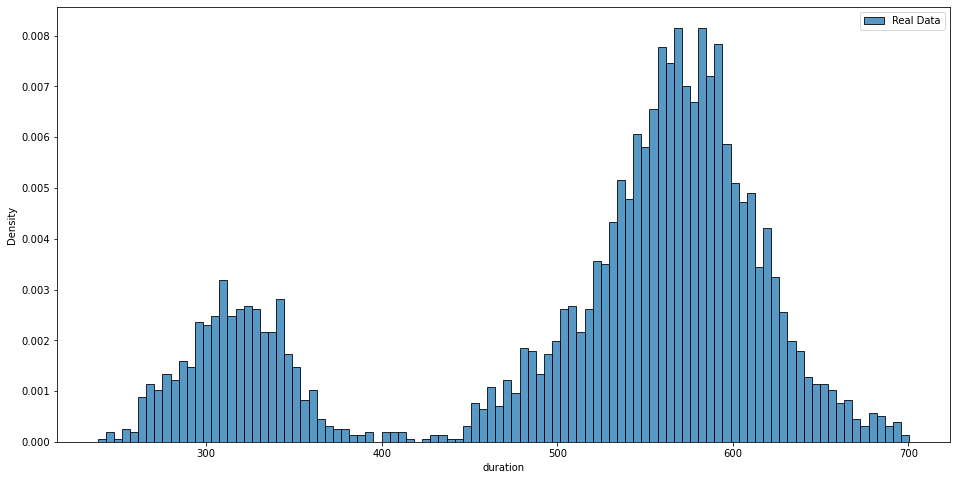

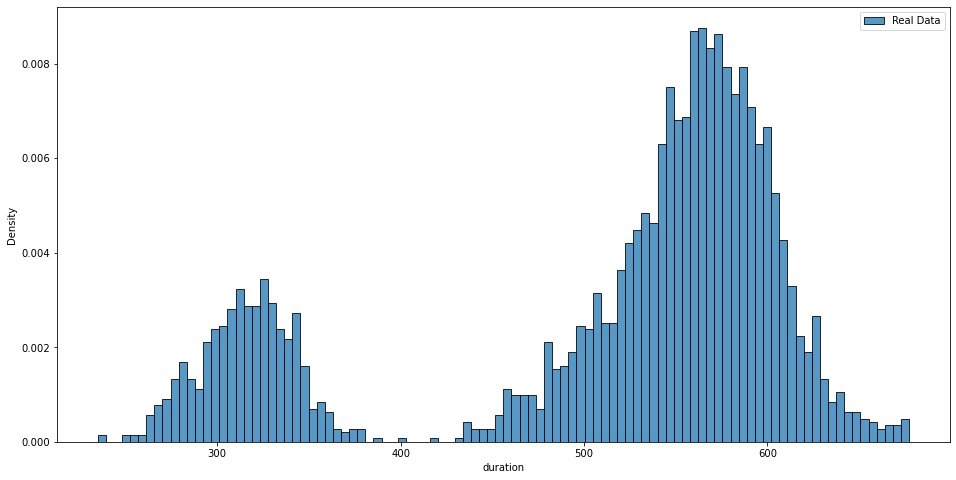

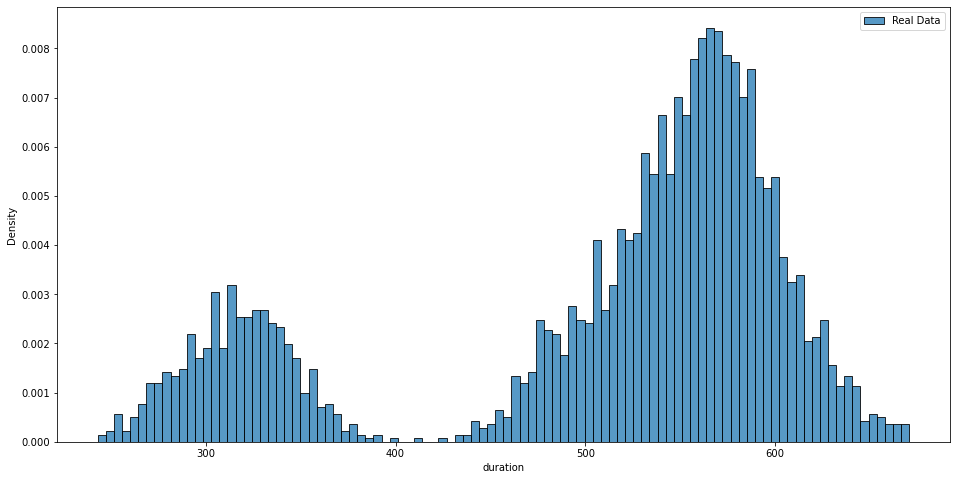

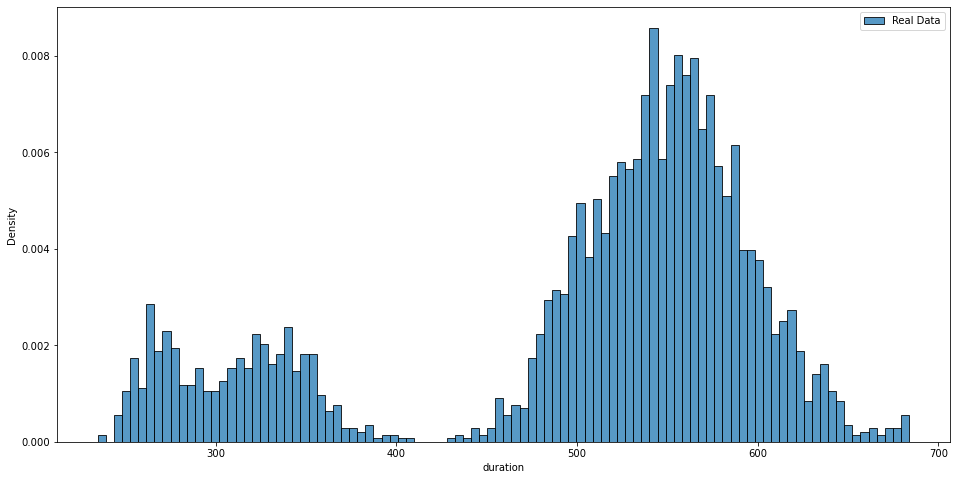

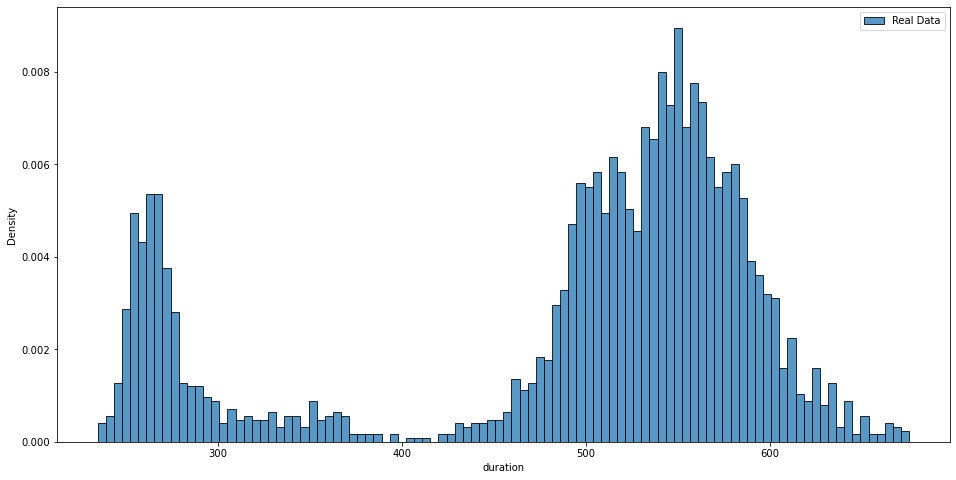

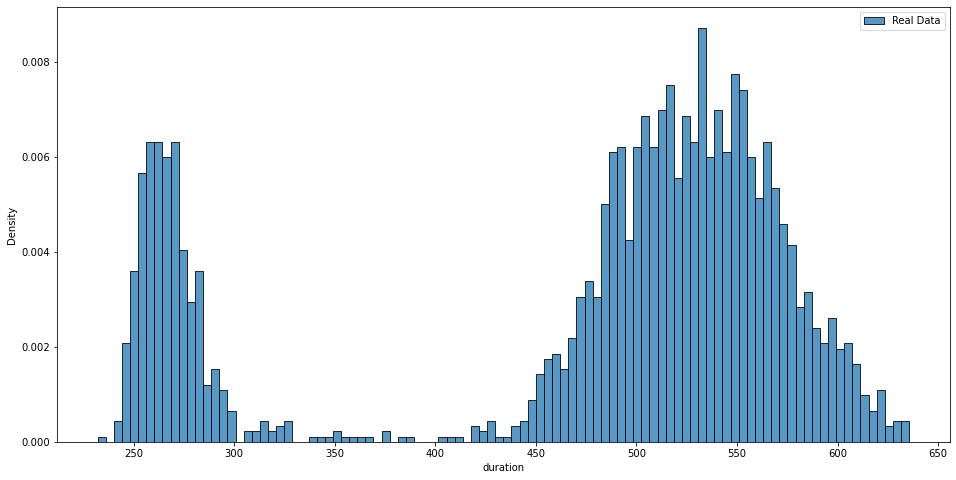

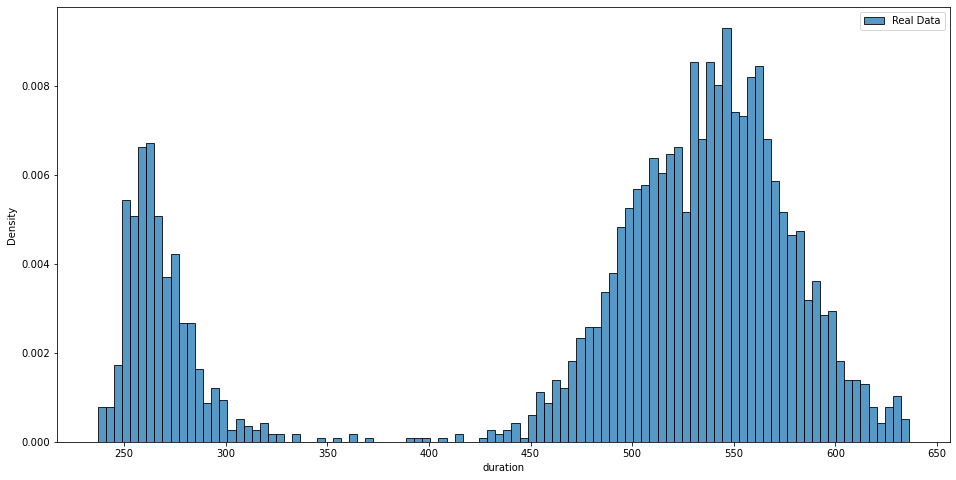

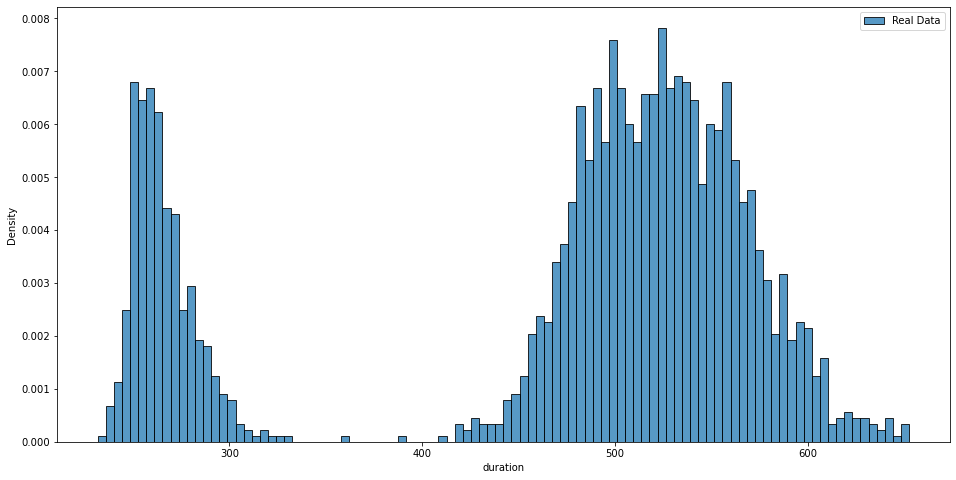

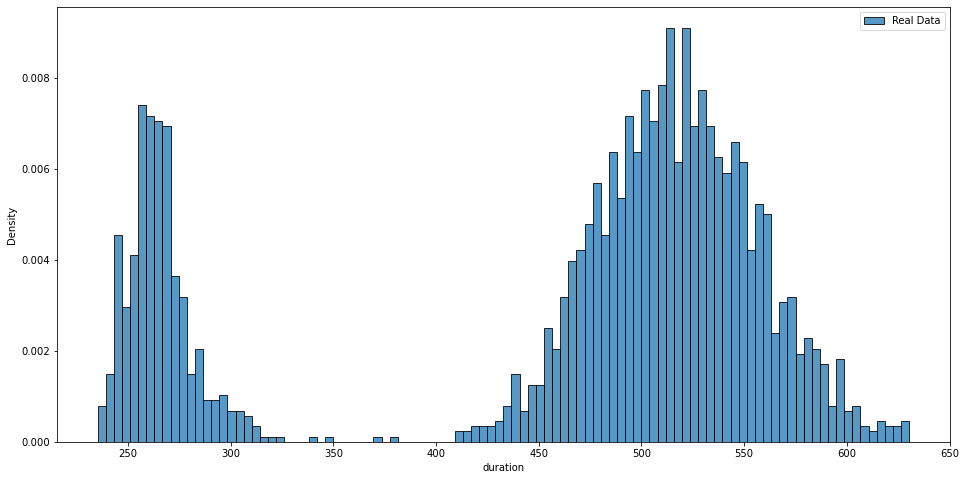

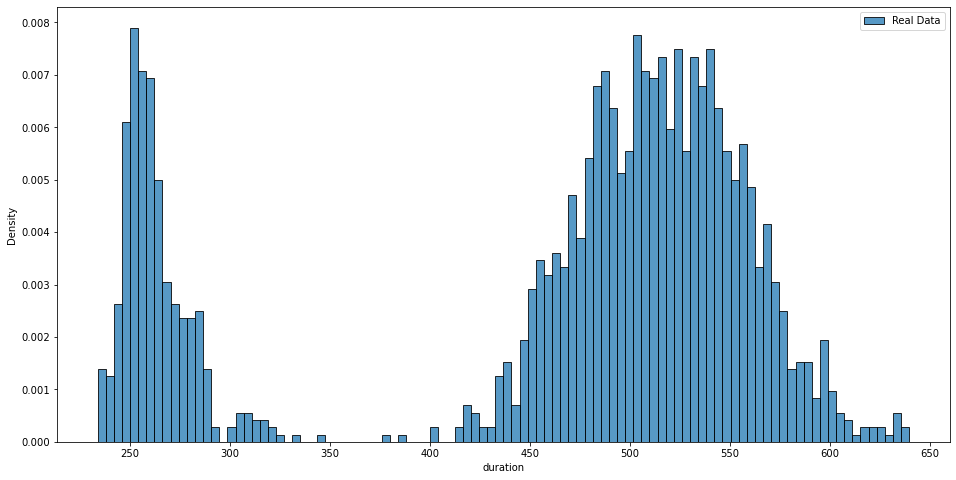

In [64]:
#0 = "/merged/jp_consensus_process_proposal.csv"
#1 = "/merged/jp_consensus_process_new_round.csv"
#2 = "/merged/jp_consensus_ensure_round_and_sync_up.csv"
#3 = "/merged/jp_consensus_process_proposal_without_sync.csv"


#Should work for 2,3 and 4
#Works for 2 and 4
frame_nr = 0
def plot_graphs(x):
    fig, ax = plt.subplots(figsize=(16,8))

    data = data_frames[frame_nr + (x*len(tmp_frames))]['duration']
    
    data = data[data >= 40]

    #Clean the data a bit
    data = data[data.between(data.quantile(0), data.quantile(.98))]
    data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]

    sns.histplot(data, ax=ax, stat="density", label="Real Data", bins=100)

    a, loc, scale = stats.gamma.fit(data)
    gamma_fit = stats.gamma(a, loc, scale)
    p_gamma_fit = stats.kstest(data, gamma_fit.cdf)

    alpha, beta, loc, scale = stats.beta.fit(data)
    beta_fit = stats.beta(alpha, beta, loc, scale)
    p_beta_fit = stats.kstest(data, beta_fit.cdf)

    #Fitting the gamma distribution
    X = np.linspace(min(data), max(data), 300)
    #ax.plot(X, gamma_fit.pdf(X), label="Estimated gamma function")
    #ax.plot(X, beta_fit.pdf(X), label="Estimated beta function")
    ax.legend();

    print("Gamma p score: " + str(p_gamma_fit))
    print("Beta p score: " + str(p_beta_fit))
    print("Percentage of data cleaned: " + str((len(data_frames[frame_nr + (x*len(tmp_frames))]['duration']) - len(data)) / len(data_frames[frame_nr + (x*len(tmp_frames))]['duration']) * 100))
    
for x in range(0, 12):
    plot_graphs(x)